In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from tqdm import tqdm
import os
import csv
import spacv


import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.model_selection import KFold
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import matplotlib.gridspec as gridspec

from deforestutils import *

from joblib import dump, load
from joblib import Parallel, delayed




/Users/annieulichney/.local/share/virtualenvs/annieulichney-xxpO7m7Z/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/annieulichney/.local/share/virtualenvs/annieulichney-xxpO7m7Z/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/annieulichney/.local/share/virtualenvs/annieulichney-xxpO7m7Z/lib/python3.8/site-packages/shap/utils/_clusteri

In [10]:
gdf = gpd.GeoDataFrame(X, geometry = gpd.points_from_xy(df_full.x, df_full.y))
gdf.columns[:-1]

Index(['year', 'rain1', 'elevation', 'slope', 'aspect', 'near_mines',
       'near_roads', 'near_hidrovia', 'indigenous_homol', 'mun_election_year',
       ...
       'urban', 'mining', 'water', 'soybean', 'rice', 'other_crop', 'coffee',
       'citrus', 'other_perennial', 'forest_lag'],
      dtype='object', length=204)

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated a

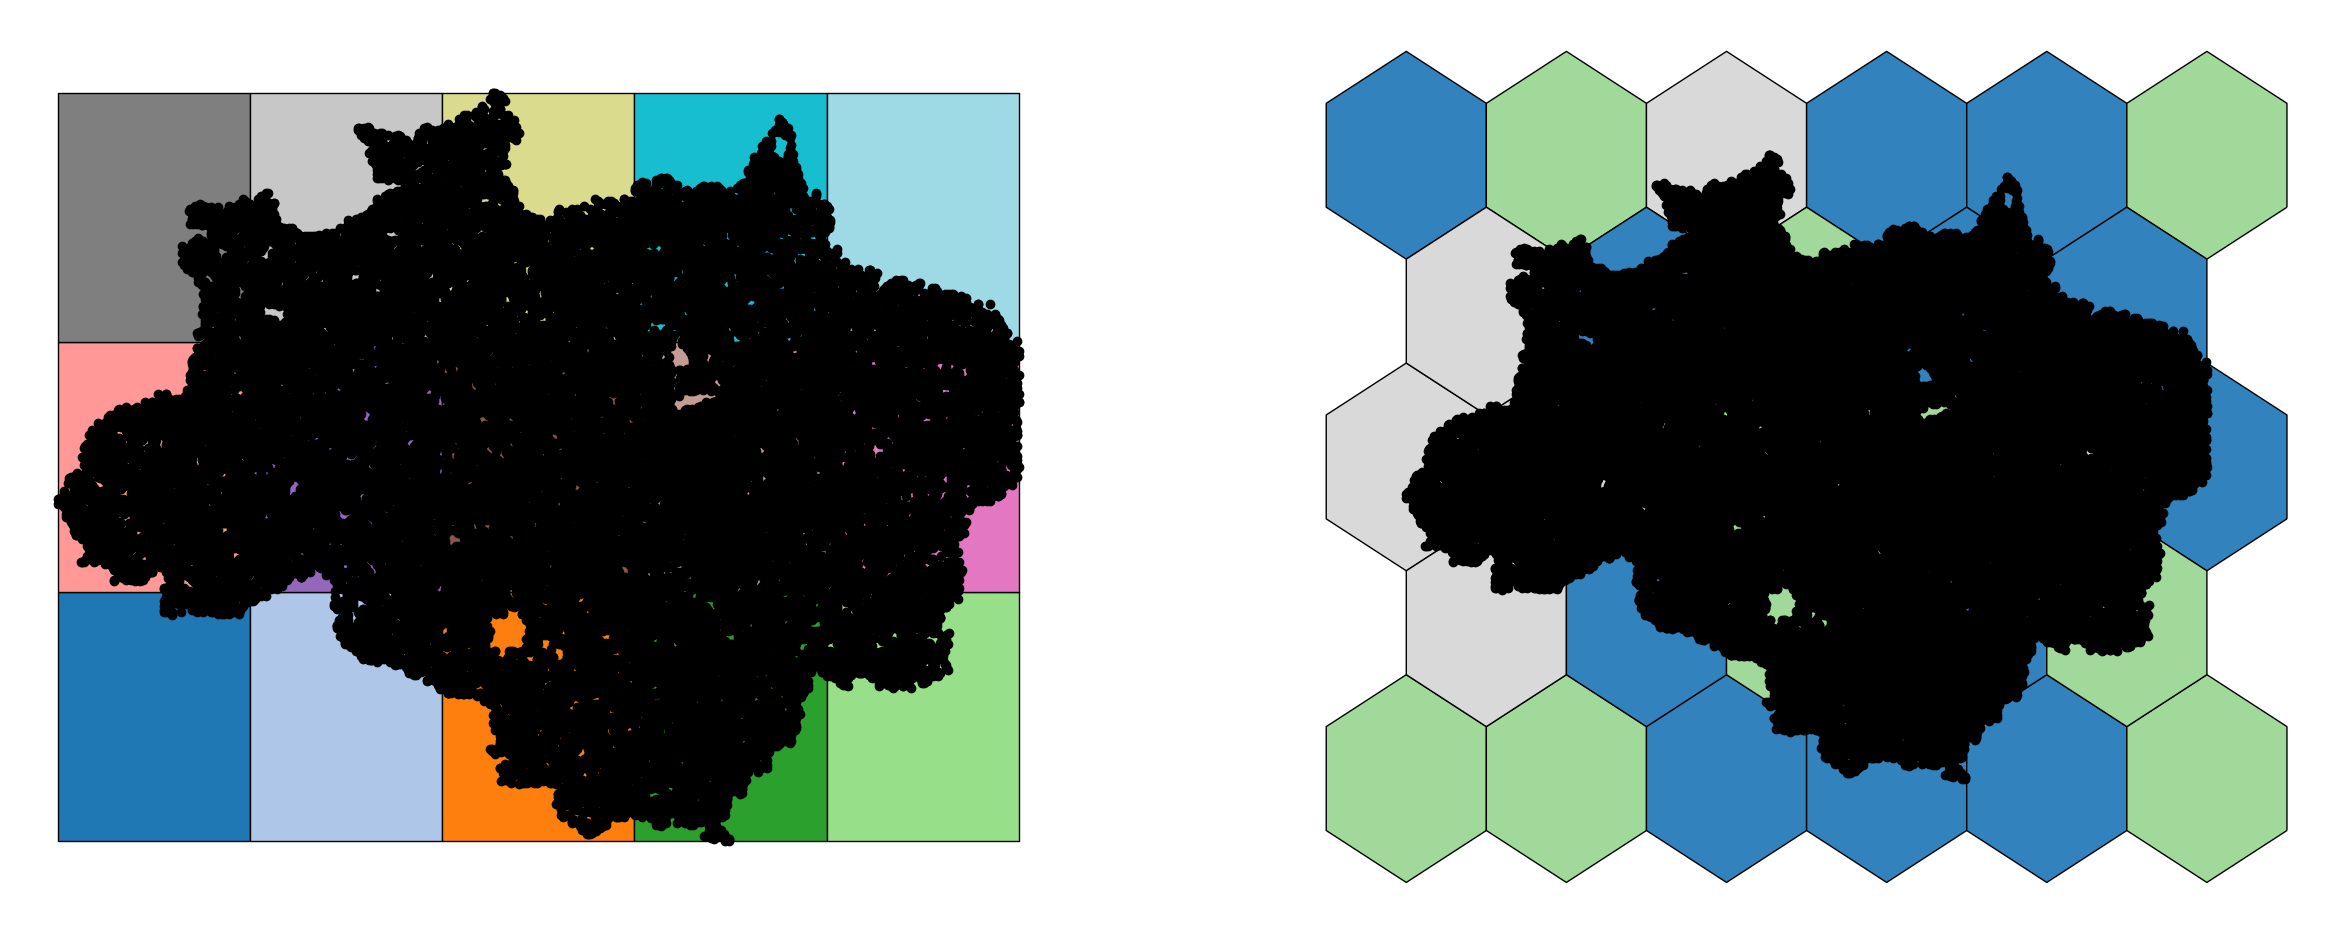

In [20]:
f, ax = plt.subplots(1,2, figsize=(30,30))
spacv.grid_builder.construct_blocks(XYs, tiles_x=5, tiles_y=3, method='unique', n_groups = 3).plot(column='grid_id',
                                edgecolor='black', cmap='tab20',ax=ax[0])

hexgrid = spacv.grid_builder.construct_blocks(XYs, tiles_x=5, tiles_y=2, 
                 method='optimized_random', n_sims=10, data=X,
                 n_groups=3, shape='hex')

hexgrid.plot(column='grid_id', cmap='tab20c',ax=ax[1], edgecolor='black')
XYs.plot(ax=ax[0], color='black'),XYs.plot(ax=ax[1], color='black')
ax[0].axis('off'), ax[1].axis('off')
plt.show()

In [23]:
gdf = gpd.GeoDataFrame(X, geometry = gpd.points_from_xy(df_full.x, df_full.y))
XYs = gdf['geometry']
X_block = gdf.columns[:-1]
skcv = spacv.HBLOCK(tiles_x = 5,tiles_y = 5, method='unique', buffer_radius=1, n_groups = 3, random_state = 42).split(XYs)
train_indices, test_indices = [list(traintest) for traintest in zip(*skcv)]
folds = [*zip(train_indices,test_indices)]

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


In [ ]:
skcv = spacv.SKCV(n_splits=3, buffer_radius=10).split(XYs)

In [ ]:
skcv = spacv.SKCV(n_splits=4, buffer_radius=10).split(XYs)

In [2]:
def get_3_fold_test_train(X, Y, df_full, method = 'municipality', SAVE = True): 
    n_folds = 3
    
    if method == 'municipality':
        munis = df_full['ID'].values
        group_kfold = GroupKFold(n_splits = n_folds)
        muni_kfold = group_kfold.split(X, Y, munis) 
        train_indices, test_indices = [list(traintest) for traintest in zip(*muni_kfold)]
        folds = [*zip(train_indices,test_indices)]

    if method == 'random':
        random_kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        random_kfold_split = random_kfold.split(X, Y) 
        train_indices, test_indices = [list(traintest) for traintest in zip(*random_kfold_split)]
        folds = [*zip(train_indices,test_indices)]
    
    if method == 'spatialkfold':
        gdf = gpd.GeoDataFrame(X, geometry = gpd.points_from_xy(df_full.x, df_full.y))
        XYs = gdf['geometry']
        skcv = spacv.SKCV(n_splits=3, buffer_radius=0.01).split(XYs)
        train_indices, test_indices = [list(traintest) for traintest in zip(*skcv)]
        folds = [*zip(train_indices,test_indices)]
    
    if method == 'hblock':
        gdf = gpd.GeoDataFrame(X, geometry = gpd.points_from_xy(df_full.x, df_full.y))
        XYs = gdf['geometry']
        skcv = spacv.HBLOCK(tiles_x = 5,tiles_y = 5, method='optimized_random', buffer_radius=1, n_groups = 3, data = df_full, random_state = 42).split(XYs)
        train_indices, test_indices = [list(traintest) for traintest in zip(*skcv)]
        folds = [*zip(train_indices,test_indices)]

    if SAVE:
        [train_1, train_2, train_3] = [folds[0][0], folds[1][0], folds[2][0]]
        pd.DataFrame([train_1, train_2, train_3]).T.to_csv('FeatureImportanceResults/TestTrainIndices/TestTrainSplit/train_indices.csv')

        [test_1, test_2, test_3] = [folds[0][1], folds[1][1], folds[2][1]]
        pd.DataFrame([test_1, test_2, test_3]).T.to_csv('FeatureImportanceResults/TestTrainIndices/TestTrainSplit/test_indices.csv')

    return folds

In [3]:
#for year
    #split points into 3 groups with METHOD
    #for i in range 3
        #train all and get feature importsnace
    #average across those 3 results of feature importance..mse..predictions.

first_time = True
GET_NULLS = False
YEAR_LIST = [2004]

RANDOM_FOREST = False
LASSO = False
GRADIENT_BOOSTING = False
SUPER_LEARNER = False
ANALYZE_PREDICTIONS = False
PLOT_FEATURE_IMPORTANCE = False
EVOLUTION = False
MSE = False

PLOT_ENTIRE_AREA = True
PLOT_FOLDS = True

SUBSET = True
SUBSET_SIZE = 30000
BASE_PATH = 'FeatureImportanceResults'
NUMBER_YEARS_TRAIN = 3

CROSS_VALIDTION_METHOD = 'random' #random, municipality, spatialkfold, 

#BASE_PATH/ FOLDER_NAME / FOLD_FOLDER_NAME

setup_base_files(BASE_PATH)

for this_start_year in tqdm(YEAR_LIST):
    START_YEAR_TRAIN = this_start_year
    YEARS_TO_TRAIN = [START_YEAR_TRAIN + u  for u in range(NUMBER_YEARS_TRAIN + 1)]
    PREDICT_YEAR = START_YEAR_TRAIN + NUMBER_YEARS_TRAIN
    FOLDER_NAME = ''.join([f'{START_YEAR_TRAIN + u}_' for u in list(range(NUMBER_YEARS_TRAIN))]) + f'PREDICT_{PREDICT_YEAR}'
    print(f'Starting fit for {this_start_year}')
    setup_year_files(BASE_PATH, FOLDER_NAME)

    df_full = get_full_data(START_YEAR_TRAIN, YEARS_TO_TRAIN)

    if SUBSET: df_full = df_full.sample(SUBSET_SIZE).reset_index(drop=True)

    X, Y = split_XY(df_full)

    folds = get_3_fold_test_train(X, Y, df_full, method = CROSS_VALIDTION_METHOD, SAVE = False)
    plot_3_folds(X, df_full, folds, f'{BASE_PATH}/{FOLDER_NAME}', method = CROSS_VALIDTION_METHOD)

    for i in range(3):
        FOLD_PATH = FOLDER_NAME + f'_FOLD{i}'
        FILE_PATH = f'{BASE_PATH}/{FOLDER_NAME}/{FOLD_PATH}'
        setup_fold_files(BASE_PATH, FOLDER_NAME, FOLD_PATH)

        train_inds, test_inds = folds[i]
        X_train, X_test, Y_train, Y_test = split_test_train(df_full, train_inds, test_inds, PREDICT_YEAR, PLOT_ENTIRE_AREA, FILE_PATH)
    

#     X_train, X_test, Y_train, Y_test = split_test_train(df_full, train_inds, test_inds, PREDICT_YEAR, PLOT_ENTIRE_AREA, NEW_INDICES, FILE_PATH, FOLDER_NAME)

#     if NEW_CV_INDICES:
#         muni_cv = get_new_cv(X_train, Y_train, FOLDER_NAME, PLOT_FOLDS, df_full, PREDICT_YEAR, FILE_PATH)
#     if not NEW_CV_INDICES:
#         muni_cv = get_prev_cv(FOLDER_NAME)

#     if GET_NULLS: get_null_count(X_train, FOLDER_NAME)
            
#     X_train = X_train.drop('geometry', axis = 1)
#     X_test = X_test.drop('geometry', axis = 1)
    

#     #random forest
#     if RANDOM_FOREST:
#         randomforest_features_df = train_random_forest(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

#     #lasso 
#     if LASSO:
#         lasso_features_df = train_lasso(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

#     #gradient boosting
#     if GRADIENT_BOOSTING:
#         gradient_boosting_features_df = train_gradient_boost(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)
    
#     #neural network
#     if NEURAL_NETWORKS:
#         nn_features_df = train_neural_network(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

#     #super learner ensemble
#     if SUPER_LEARNER:
#         base_learners = get_base_learners(FOLDER_NAME)
#         super_learner_features_df = train_super_learner(X_train, Y_train, X_test, Y_test, FILE_PATH, muni_cv, base_learners, FOLDER_NAME)

#     #visualize
#     if ANALYZE_PREDICTIONS:
#         yhat_list = get_yhat_list(FOLDER_NAME)
#         visualize_predictions(yhat_list, Y_test, FILE_PATH, FOLDER_NAME)
#         visualize_predictions_single_plot(yhat_list, Y_test, FILE_PATH, FOLDER_NAME)

#     if PLOT_FEATURE_IMPORTANCE:
#         for method in ['randomforest', 'lasso', 'gradientboosting', 'neuralnetwork', 'superlearner']:
#             plot_feature_importance(FILE_PATH, FOLDER_NAME, method, use_abs = True)
#             plot_feature_importance(FILE_PATH, FOLDER_NAME, method, SHOW = False, INCLUDE_FOREST = False, use_abs = True)

#         plot_feature_importance_all_methods(X_train, FILE_PATH, FOLDER_NAME, method, SHOW = True, INCLUDE_FOREST = True, use_abs = True)
#         plot_feature_importance_all_methods(X_train, FILE_PATH, FOLDER_NAME, method, SHOW = False, INCLUDE_FOREST = False, use_abs = True)

# if EVOLUTION:
#     #analysis for all years:
#     for method_string in ['randomforest', 'lasso', 'gradientboosting', 'neuralnetwork', 'superlearner', 'avg']:
#         feature_importance_evolution(method_string, INCLUDE_FOREST = False)

# if MSE:
#     plot_MSE()
    

Base Files setup.


  0%|          | 0/1 [00:00<?, ?it/s]

Starting fit for 2004
Read in data for 2004
Years in data: [2004 2005 2006 2007]
Number of rows in data: (665048, 216)


The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
invalid value encountered in true_divide
The `op` parameter is deprecated a

NameError: name 'method' is not defined

<Axes: >

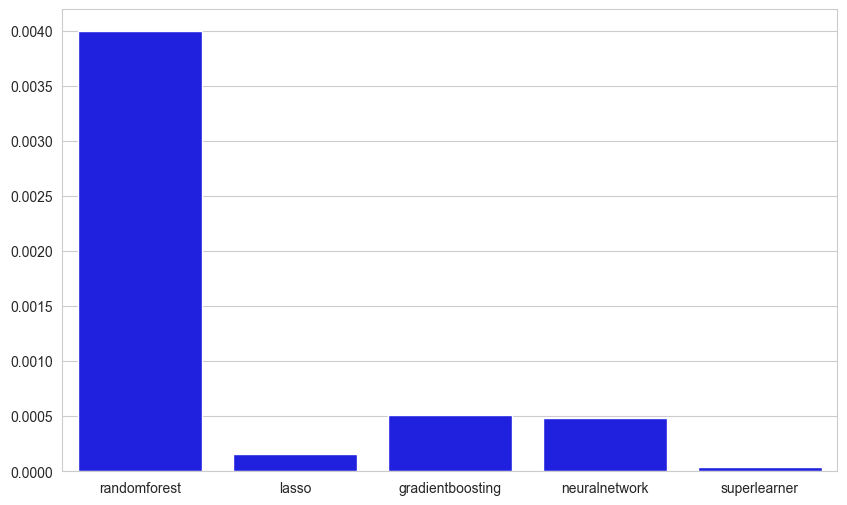

In [225]:
file_path = FILE_PATH + '/performance.txt'
with open(file_path, "r") as file:
    lines = file.readlines()

content_list = [line.strip() for line in lines][2:]
split_list = [s.split(' MSE: ') for s in content_list]

labels = [e[0] for e in split_list]
values = [float(e[1]) for e in split_list]

sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(y=values, x=labels, color='blue', orient = 'v')


In [222]:
values

[0.003996678030490013,
 0.0001577119711700281,
 0.0005126619858697259,
 0.0004796600448663341,
 3.938500153292077e-05]

In [76]:
def plot_feature_importance(FILE_PATH, FOLDER_NAME, method, SHOW = True, INCLUDE_FOREST = True, use_abs = True):
    file_path = FILE_PATH + 'FeatureImportance/' + method + '.csv'

    df = pd.read_csv(file_path, index_col=0)
    file_path_save = FILE_PATH + 'FeatureImportance/' + 'features_' + method

    if not INCLUDE_FOREST:
        df = df[~df.Feature.isin(['forest_lag', 'forest_formation'])]
        file_path_save = FILE_PATH + 'FeatureImportance/' + 'features_exclude_forest_vars_' + method

    abs_sum = df['Coeff'].abs().sum()
    df['Coeff'] = df['Coeff'] / abs_sum

    coeff_values = df['Coeff'].head(10)
    feature_labels = df['Feature'].head(10)

    if abs:
        coeff_values = (abs(coeff_values))

    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))
    sns.barplot(x=coeff_values, y=feature_labels, color='green')

    # Set plot title and labels
    plt.title(FOLDER_NAME + ' ' + method.upper() )
    #plt.xlabel('Abs')
    #plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig(file_path_save)
    if SHOW: plt.show()

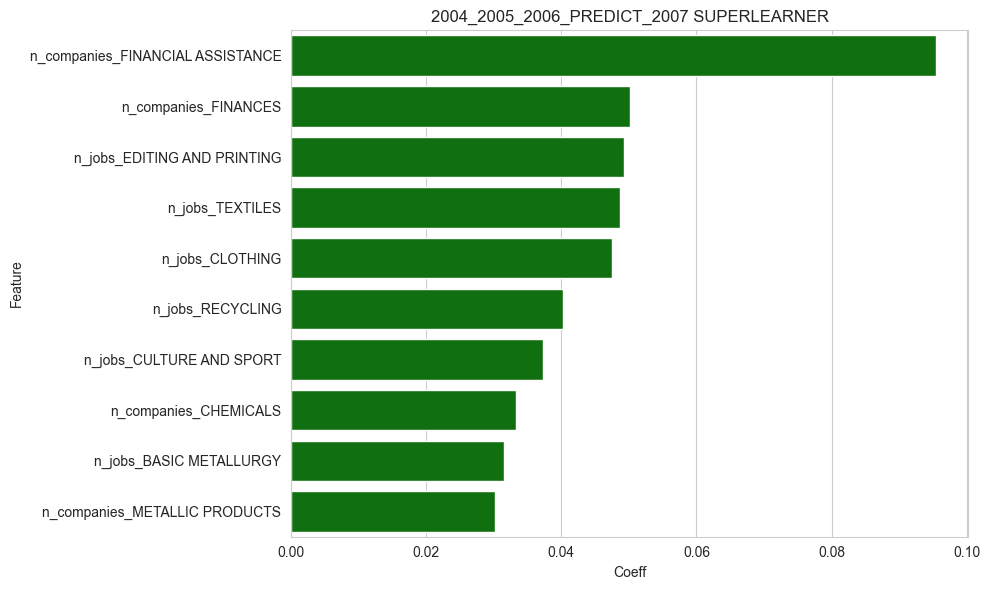

In [78]:
plot_feature_importance(FILE_PATH, FOLDER_NAME, method, SHOW = True, INCLUDE_FOREST = False, use_abs = True)

In [71]:
df.head()

,Feature,Coeff
203,forest_lag,-0.479329
187,forest_formation,0.479158
37,n_companies_FINANCIAL ASSISTANCE,-0.003964
45,n_companies_FINANCES,0.002084
94,n_jobs_EDITING AND PRINTING,0.002048


,Feature,Coeff
37,n_companies_FINANCIAL ASSISTANCE,-0.003964
45,n_companies_FINANCES,0.002084
94,n_jobs_EDITING AND PRINTING,0.002048
127,n_jobs_TEXTILES,0.002019
116,n_jobs_CLOTHING,0.001973
...,...,...
198,rice,0.000000
161,term_limited_seat,0.000000
200,coffee,0.000000
201,citrus,0.000000
